# Data Loading and Exploration

In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import pylab as pl

# Data Loading

In [2]:
print('Loading park zone data')
df1 = gpd.read_file('raw_data/Parks Zones.geojson')
print('Loading sidewalk data')
df2 = gpd.read_file('raw_data/Sidewalk Centerline.geojson')
print('Loading street data')
df3 = gpd.read_file('raw_data/NYC Street Centerline (CSCL).geojson')
# use API, database too big
#print('Loading tree data')
#df4 = gpd.read_file('raw_data/2015 Street Tree Census - Tree Data.geojson')
print('Done')

Loading park zone data
Loading sidewalk data
Loading street data
Done


## Select data by Borough

In [3]:
borough = 'M'
boroughs = {'M': '1',  # Manhattan
            '?': '2',  # Bronx
            '?': '3',  # Brooklyn
            '?': '4',  # Queens
            '?': '5'}  # Staten Island
# missing boroughs are: {'B', 'Q', 'R', 'X'}

In [4]:
# selecting Manhattan
borough_df1 = df1.loc[df1['borough'] == borough]

In [5]:
borough_df2 = df2

In [6]:
# boroughs are {}'1', '2', '3', '4', '5', '6'}
# selecting Manhattan
borough_df3 = df3.loc[df3['borocode'] == boroughs[borough]]

## Plotting Borough Data

Text(0.5,1,'NYC Map of Running Areas')

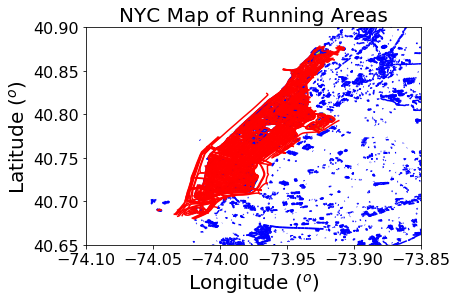

In [7]:
fig, ax1 = pl.subplots()#figsize=(12, 12))
borough_df1.plot(ax=ax1, color='y', label='x')  # roads
borough_df2.plot(ax=ax1, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax1, color='r', label='z')  # parks

# to do: remove data outside of proper borough
x_range = [-74.05, -73.9]
y_range = [40.65, 40.9]
x0 = pl.mean(x_range)
y0 = pl.mean(y_range)
dx = x_range[1] - x_range[0]
dy = y_range[1] - y_range[0]
dd = max([dx, dy]) / 2.
pl.xlim([x0-dd, x0+dd])
pl.ylim([y0-dd, y0+dd])
pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})


## Zoom on Central Park

In [9]:
lon0_deg = -73.97
lat0_deg = 40.77
r_deg = 0.01
borough_df1 = select_data(borough_df1, lon0_deg, lat0_deg, r_deg)
borough_df2 = select_data(borough_df2, lon0_deg, lat0_deg, r_deg)
borough_df3 = select_data(borough_df3, lon0_deg, lat0_deg, r_deg)

/home/aubin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/aubin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/aubin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

## Select Subset of the Data for Proof of Concept

In [8]:
def select_data(df, lon0_deg, lat0_deg, r_deg):
    """
    drops the data outside a radius r_deg around (lon0_deg, lat0_deg)
    """
    df['rep_x_rad'] = pd.Series([df['geometry'].iloc[i].representative_point().x*pl.pi/180. for i in range(len(df.index))], index=df.index)
    df['rep_y_rad'] = pd.Series([df['geometry'].iloc[i].representative_point().y*pl.pi/180. for i in range(len(df.index))], index=df.index)

    lon0 = pl.float64(lon0_deg)*pl.pi/180.  # lambda
    lat0 = pl.float64(lat0_deg)*pl.pi/180.  # phi

    # rounding could be an issue...
    df['diff_to_ref_rad'] = pl.arccos(pl.sin(lat0)*pl.sin(df['rep_y_rad'])+pl.cos(lat0)*pl.cos(df['rep_y_rad'])*pl.cos(df['rep_x_rad']-lon0))
    invalid = df['diff_to_ref_rad'] * 180./pl.pi > r_deg
    df.drop(df.index[invalid], inplace=True)
        
    return df

## Plot Sub-Data

Text(0.5,1,'NYC Map of Running Areas')

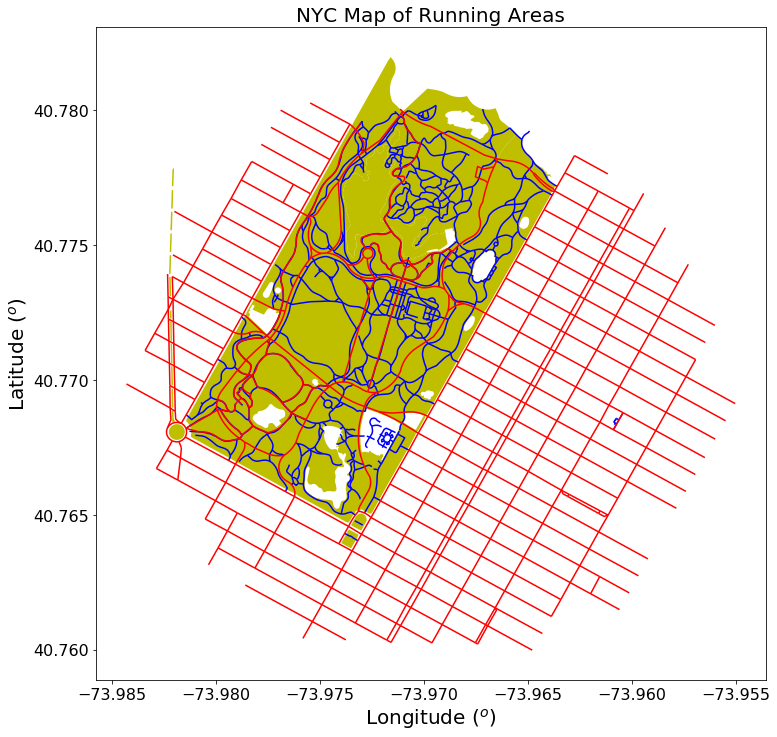

In [17]:
# plotting the selected data
fig, ax2 = pl.subplots(figsize=(12, 12))
borough_df1.plot(ax=ax2, color='y', label='x')  # roads
borough_df2.plot(ax=ax2, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax2, color='r', label='z')  # parks

# zoom on a specific region
#x_range = [-73.99, -73.95]
#y_range = [40.75, 40.8]
#x0 = pl.mean(x_range)
#y0 = pl.mean(y_range)
#dx = x_range[1] - x_range[0]
#dy = y_range[1] - y_range[0]
#dd = max([dx, dy]) / 2.
#pl.xlim([x0-dd, x0+dd])
#pl.ylim([y0-dd, y0+dd])
pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})

## Reformats Data

In [127]:
# write selected data to csv file
data_for_df = {'lon_start': [], 'lat_start': [], 'lon_end': [], 'lat_end': [], 'distance':[], 'type': [],
               'connections_start': [], 'connections_end': []}
# not all start/end point present twice (for instance, T shapes)
#print(len(borough_df3.index))
for i in range(len(borough_df3.index)):
    data_for_df['lon_start'].append(borough_df3['geometry'].iloc[i].boundary[0].x)
    data_for_df['lat_start'].append(borough_df3['geometry'].iloc[i].boundary[0].y)
    data_for_df['lon_end'].append(borough_df3['geometry'].iloc[i].boundary[1].x)
    data_for_df['lat_end'].append(borough_df3['geometry'].iloc[i].boundary[1].y)
    data_for_df['distance'].append(borough_df3['geometry'].iloc[i].length)
    data_for_df['type'].append('street')
    data_for_df['connections_start'].append([])
    data_for_df['connections_end'].append([])
for i in range(len(borough_df2.index)):
    data_for_df['lon_start'].append(borough_df2['geometry'].iloc[i].boundary[0].x)
    data_for_df['lat_start'].append(borough_df2['geometry'].iloc[i].boundary[0].y)
    data_for_df['lon_end'].append(borough_df2['geometry'].iloc[i].boundary[1].x)
    data_for_df['lat_end'].append(borough_df2['geometry'].iloc[i].boundary[1].y)
    data_for_df['distance'].append(borough_df2['geometry'].iloc[i].length)
    data_for_df['type'].append('sidewalk')
    data_for_df['connections_start'].append([])
    data_for_df['connections_end'].append([])
#len(data_for_df['connections_start']), data_for_df['connections_start']

## Make Connections between vertices

In [128]:
index_list = [5, 87, 88, 149]
for i in range(len(data_for_df['lon_start'])):
    for j in range(i+1, len(data_for_df['lon_start'])):
#for k in range(len(index_list)):
#    for kk in range(k+1, len(index_list)):
#        i = index_list[k]
#        j = index_list[kk]
        #print(i, j)
        #print(data_for_df["lon_start"][i], data_for_df["lat_start"][i])
        #print(data_for_df["lon_end"][i], data_for_df["lat_end"][i])
        #print(data_for_df["lon_start"][j], data_for_df["lat_start"][j])
        #print(data_for_df["lon_end"][j], data_for_df["lat_end"][j])
        if data_for_df["lon_start"][i] == data_for_df["lon_start"][j] and data_for_df["lat_start"][i] == data_for_df["lat_start"][j]:
            #print('start-start')
            data_for_df['connections_start'][i].append(j)
            data_for_df['connections_start'][j].append(i)
        if data_for_df["lon_start"][i] == data_for_df["lon_end"][j] and data_for_df["lat_start"][i] == data_for_df["lat_end"][j]:
            #print('start-end')
            data_for_df['connections_start'][i].append(j)
            data_for_df['connections_end'][j].append(i)
        if data_for_df["lon_end"][i] == data_for_df["lon_start"][j] and data_for_df["lat_end"][i] == data_for_df["lat_start"][j]:
            #print('end-start')
            data_for_df['connections_end'][i].append(j)
            data_for_df['connections_start'][j].append(i)
        if data_for_df["lon_end"][i] == data_for_df["lon_end"][j] and data_for_df["lat_end"][i] == data_for_df["lat_end"][j]:
            #print('end-end')
            data_for_df['connections_end'][i].append(j)
            data_for_df['connections_end'][j].append(i)
#pl.array(data_for_df["connections_start"])[index_list]

## Write DataFrame to File

In [129]:
new_df = pd.DataFrame(data_for_df, columns=['lon_start', 'lat_start', 'lon_end', 'lat_end', 'distance', 'type', 'connections_start', 'connections_end'])
new_df.to_csv("selected_data.csv")
new_df.iloc[index_list]

,lon_start,lat_start,lon_end,lat_end,distance,type,connections_start,connections_end
5,-73.976458,40.775533,-73.975955,40.776220,0.000851,street,"[87, 149]","[68, 88, 185]"
87,-73.976912,40.774909,-73.976458,40.775533,0.000771,street,"[468, 569]","[5, 149]"
88,-73.978799,40.777413,-73.975955,40.776220,0.003084,street,"[515, 536]","[5, 68, 185]"
149,-73.979287,40.776725,-73.976458,40.775533,0.003070,street,"[493, 536]","[5, 87]"


## Debugging Plot to Show Intersections

-73.97073018211728 40.77637907108142


Text(0.5,1,'NYC Map of Running Areas')

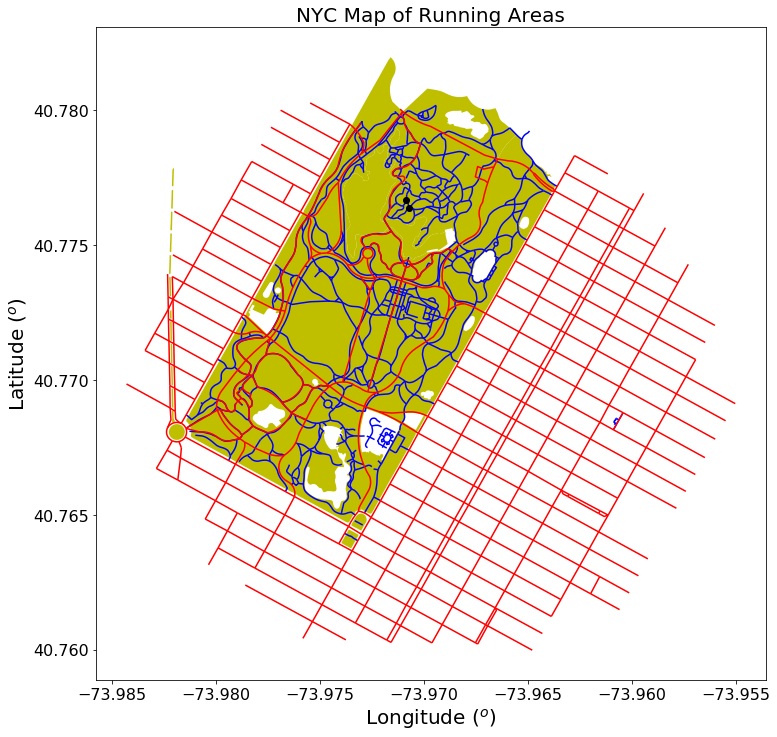

In [132]:
# plotting the selected data
fig, ax2 = pl.subplots(figsize=(12, 12))
borough_df1.plot(ax=ax2, color='y', label='x')  # roads
borough_df2.plot(ax=ax2, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax2, color='r', label='z')  # parks

n = -1
pl.plot(data_for_df['lon_start'][n], data_for_df['lat_start'][n], 'ok')
pl.plot(data_for_df['lon_end'][n], data_for_df['lat_end'][n], 'ok')
print(data_for_df['lon_start'][n], data_for_df['lat_start'][n])

pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})

In [131]:
new_df.iloc[[5, 6]]

,lon_start,lat_start,lon_end,lat_end,distance,type,connections_start,connections_end
5,-73.976458,40.775533,-73.975955,40.776220,0.000851,street,"[87, 149]","[68, 88, 185]"
6,-73.978292,40.778096,-73.975459,40.776899,0.003076,street,[515],"[185, 561]"
